In [7]:

# Imports

import pandas as pd
import re
import html
from bs4 import BeautifulSoup

import nltk
from nltk.corpus import stopwords

nltk.download("stopwords")  # run only once
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/amitianeesh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:

QUESTIONS_PATH = "../data/raw/Questions.csv"
ANSWERS_PATH = "../data/raw/Answers.csv"
TAGS_PATH = "../data/raw/Tags.csv"

QUESTIONS_OUTPUT_PATH = "../data/processed/questions_clean.csv"
ANSWERS_OUTPUT_PATH = "../data/processed/answers_clean.csv"

CHUNK_SIZE = 50000  # rows processed at a time(large so chunckwise)


counting questions/answers/tags

In [9]:

question_count = sum(
    len(chunk)
    for chunk in pd.read_csv(QUESTIONS_PATH, encoding="latin1", chunksize=100000)
)

question_count


1264216

In [10]:
answer_count = sum(
    len(chunk)
    for chunk in pd.read_csv(ANSWERS_PATH, encoding="latin1", chunksize=100000)
)

answer_count


2014516

In [12]:
tag_count = sum(
    len(chunk)
    for chunk in pd.read_csv(TAGS_PATH, encoding="latin1", chunksize=100000)
)

tag_count


3750994

In [13]:
dataset_summary = pd.DataFrame({
    "TYpe": ["Questions", "Answers", "Tags"],
    "Count": [question_count, answer_count, tag_count]
})

dataset_summary


,TYpe,Count
0,Questions,1264216
1,Answers,2014516
2,Tags,3750994


In [14]:
sample_df_ques= pd.read_csv(
    ANSWERS_PATH,
    encoding="latin1",
    nrows=5
)

# sample_df_ques.head()
sample_df_ques.head(1)


,Id,OwnerUserId,CreationDate,ParentId,Score,Body
0,92,61,2008-08-01T14:45:37Z,90,13,"<p><a href=""http://svnbook.red-bean.com/"">Vers..."


In [15]:
sample_df_ques= pd.read_csv(
    QUESTIONS_PATH,
    encoding="latin1",
    nrows=5
)

sample_df_ques.shape


(5, 7)

In [16]:
from bs4 import XMLParsedAsHTMLWarning
import warnings

# Suppress XML warning once
warnings.filterwarnings("ignore", category=XMLParsedAsHTMLWarning)

In [17]:
def clean_text_pipeline(text):
    if pd.isna(text):
        return ""

    # Decode HTML entities (e.g., &lt; → <)
    text = html.unescape(text)
    try:
        # Remove HTML/XML tags
        text = BeautifulSoup(text, "html.parser").get_text()
    except Exception:
        return ""
    
    # Convert to lowercase
    text = text.lower()

    # Remove non-alphabetic characters
    text = re.sub(r"[^a-z\s]", " ", text)

    # Normalize multiple spaces
    text = re.sub(r"\s+", " ", text)

    # Tokenize
    tokens = text.split()

    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]

    # Join back
    text = " ".join(tokens)

    return text.strip()


In [18]:
# Test Cleaning on Small Subset
test_df = pd.read_csv(
    QUESTIONS_PATH,
    encoding="latin1",
    nrows=10000
)

test_df["raw_text"] = (
    test_df["Title"].fillna("") + " " +
    test_df["Body"].fillna("")
)

test_df["clean_text"] = test_df["raw_text"].apply(clean_text_pipeline)

sample = test_df[["raw_text", "clean_text"]].iloc[0]

print("RAW TEXT:\n", sample["raw_text"][:500])
print("\nCLEAN TEXT:\n", sample["clean_text"][:500])


RAW TEXT:
 SQLStatement.execute() - multiple queries in one statement <p>I've written a database generation script in <a href="http://en.wikipedia.org/wiki/SQL">SQL</a> and want to execute it in my <a href="http://en.wikipedia.org/wiki/Adobe_Integrated_Runtime">Adobe AIR</a> application:</p>

<pre><code>Create Table tRole (
      roleID integer Primary Key
      ,roleName varchar(40)
);
Create Table tFile (
    fileID integer Primary Key
    ,fileName varchar(50)
    ,fileDescription varchar(500)
    ,thum

CLEAN TEXT:
 sqlstatement execute multiple queries one statement written database generation script sql want execute adobe air application create table trole roleid integer primary key rolename varchar create table tfile fileid integer primary key filename varchar filedescription varchar thumbnailid integer fileformatid integer categoryid integer isfavorite boolean dateadded date globalaccesscount integer lastaccesstime date downloadcomplete boolean isnew boolean isspotlight boolean

In [19]:
# Full Dataset Cleaning (Chunk Processing)
first_chunk = True

for chunk in pd.read_csv(
    QUESTIONS_PATH,
    encoding="latin1",
    chunksize=CHUNK_SIZE
):

    # Combine title and body
    chunk["raw_text"] = (
        chunk["Title"].fillna("") + " " +
        chunk["Body"].fillna("")
    )

    # Apply cleaning pipeline
    chunk["clean_text"] = chunk["raw_text"].apply(clean_text_pipeline)

    # Keep only relevant columns
    processed_chunk = chunk[["Id", "Score", "clean_text"]]

    # Write incrementally
    processed_chunk.to_csv(
        QUESTIONS_OUTPUT_PATH,
        mode="w" if first_chunk else "a",
        header=first_chunk,
        index=False
    )

    first_chunk = False

print(" Full preprocessing complete.")


 Full preprocessing complete.


In [21]:
import os

os.makedirs(os.path.dirname(QUESTIONS_OUTPUT_PATH), exist_ok=True)


In [22]:
# verify
clean_df_sample = pd.read_csv(QUESTIONS_OUTPUT_PATH, nrows=5)

clean_df_sample.head()


,Id,Score,clean_text
0,80,26,sqlstatement execute multiple queries one stat...
1,90,144,good branching merging tutorials tortoisesvn r...
2,120,21,asp net site maps anyone got experience creati...
3,180,53,function creating color wheels something pseud...
4,260,49,adding scripting functionality net application...


In [23]:
original_count = sum(
    len(chunk)
    for chunk in pd.read_csv(QUESTIONS_PATH, encoding="latin1", chunksize=100000)
)

clean_count = sum(
    len(chunk)
    for chunk in pd.read_csv(QUESTIONS_OUTPUT_PATH, chunksize=100000)
)

print("Original rows:", original_count)
print("Cleaned rows:", clean_count)


Original rows: 1264216
Cleaned rows: 1264216


answers cleaning

In [24]:
sample_df_ans= pd.read_csv(
    ANSWERS_PATH,
    encoding="latin1",
    nrows=5
)

# sample_df_ans.head()
sample_df_ques.head()


,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


In [ ]:
# # Test Cleaning on Small Subset of ans
# test_df_ans = pd.read_csv(
#     ANSWERS_PATH,
#     encoding="latin1",
#     nrows=10000
# )

# test_df_ans["raw_text"] = (
#     test_df_ans["Body"].fillna("")
# )

# test_df_ans["clean_text"] = test_df_ans["raw_text"].apply(clean_text_pipeline)

# sample = test_df_ans[["raw_text", "clean_text"]].iloc[0]

# print("RAW TEXT:\n", sample["raw_text"][:500])
# print("\nCLEAN TEXT:\n", sample["clean_text"][:500])


NameError: name 'clean_text_pipeline' is not defined

In [25]:
# Full Dataset Cleaning (Chunk Processing)
first_chunk = True

for chunk in pd.read_csv(
    ANSWERS_PATH,
    encoding="latin1",
    chunksize=CHUNK_SIZE
):

    # Combine title and body
    chunk["raw_text"] = (
        chunk["Body"].fillna("")
    )

    # Apply cleaning pipeline
    chunk["clean_text"] = chunk["raw_text"].apply(clean_text_pipeline)

    # Keep only relevant columns
    processed_chunk = chunk[["Id","ParentId", "Score", "clean_text"]]

    # Write incrementally
    processed_chunk.to_csv(
        ANSWERS_OUTPUT_PATH,
        mode="w" if first_chunk else "a",
        header=first_chunk,
        index=False
    )

    first_chunk = False

print(" Full preprocessing complete.")


 Full preprocessing complete.


In [26]:
import pandas as pd
answers_sample = pd.read_csv("../data/processed/answers_clean.csv", nrows=5)
answers_sample.head()

,Id,ParentId,Score,clean_text
0,92,90,13,version control subversion good resource sourc...
1,124,80,12,wound using kind hack actually works pretty we...
2,199,180,1,read somewhere human eye distinguish less valu...
3,269,260,4,yes thought soon figured another domain specif...
4,307,260,28,oleg shilo c script solution code project real...


In [27]:
# TF-IDF VECTORIZATION

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import save_npz

# Load cleaned questions
clean_questions = pd.read_csv("../data/processed/questions_clean.csv")

vectorizer = TfidfVectorizer(
    max_features=10000,
    min_df=5,
    max_df=0.8,
    ngram_range=(1,2),
    sublinear_tf=True
)

tfidf_questions = vectorizer.fit_transform(clean_questions["clean_text"].fillna(""))

import joblib
joblib.dump(vectorizer, "../data/processed/tfidf_vectorizer.pkl")

print("Questions TF-IDF Shape:", tfidf_questions.shape)

# Save sparse matrix
save_npz("../data/processed/questions_tfidf.npz", tfidf_questions)

print("Questions TF-IDF saved successfully.")

Questions TF-IDF Shape: (1264216, 10000)
Questions TF-IDF saved successfully.


In [28]:
import pandas as pd
# Load the newly cleaned answers (now has ParentId)
answers_clean = pd.read_csv("../data/processed/answers_clean.csv")
print("Answers shape:", answers_clean.shape)
print(answers_clean.head(3))

Answers shape: (2014516, 4)
    Id  ParentId  Score                                         clean_text
0   92        90     13  version control subversion good resource sourc...
1  124        80     12  wound using kind hack actually works pretty we...
2  199       180      1  read somewhere human eye distinguish less valu...


In [35]:
# Group all answers by the question they belong to (ParentId = Question Id)
answer_stats = answers_clean.groupby("ParentId").agg(
    avg_answer_score=("Score", "mean"),
    answer_count=("Score", "count"),
    max_answer_score=("Score", "max")
).reset_index()
# Rename ParentId to question_id for clarity
answer_stats.rename(columns={"ParentId": "question_id"}, inplace=True)
print("Answer stats shape:", answer_stats.shape)
answer_stats.head(5)

Answer stats shape: (1102568, 4)


,question_id,avg_answer_score,answer_count,max_answer_score
0,80,6.333333,3,12
1,90,11.333333,3,19
2,120,9.000000,1,9
3,180,6.000000,9,21
4,260,7.000000,9,28


Matplotlib is building the font cache; this may take a moment.


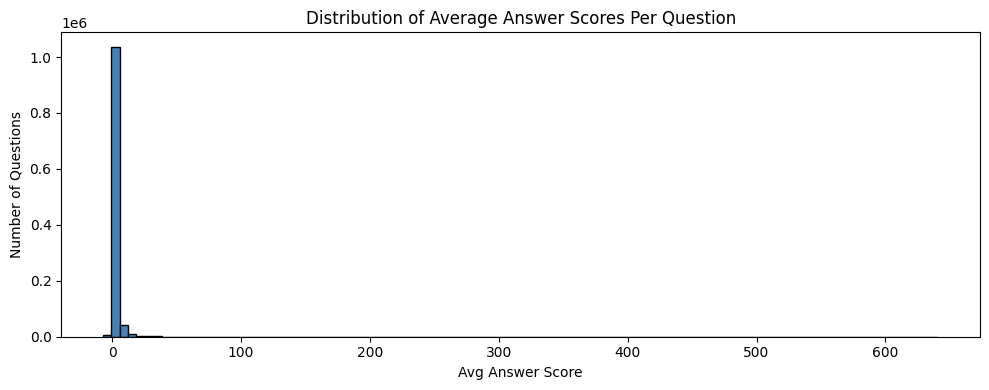

Min: -7.0
Max: 641.0
Mean: 1.82
Median: 1.0


In [36]:
# STEP 3: Bayesian Smoothing + Normalize to 0-1
# (Replaces the simple min-max normalization)

global_mean = answer_stats["avg_answer_score"].mean()
C = answer_stats["answer_count"].mean()  # confidence factor

print(f"Global mean score: {global_mean:.2f}")
print(f"Confidence factor C: {C:.2f}")

# Apply Bayesian smoothing
answer_stats["bayesian_avg_score"] = (
    (C * global_mean + answer_stats["avg_answer_score"] * answer_stats["answer_count"])
    / (C + answer_stats["answer_count"])
)

# Normalize to 0-1
min_b = answer_stats["bayesian_avg_score"].min()
max_b = answer_stats["bayesian_avg_score"].max()

answer_stats["avg_score_normalized"] = (
    (answer_stats["bayesian_avg_score"] - min_b) / (max_b - min_b)
)

print("\nNormalized score range:")
print("Min:", answer_stats["avg_score_normalized"].min())
print("Max:", answer_stats["avg_score_normalized"].max())
print("Mean:", answer_stats["avg_score_normalized"].mean().round(4))

answer_stats.head(5)


Global mean score: 1.82
Confidence factor C: 1.83

Normalized score range:
Min: 0.0
Max: 1.0
Mean: 0.0094


,question_id,avg_answer_score,answer_count,max_answer_score,bayesian_avg_score,avg_score_normalized
0,80,6.333333,3,12,4.623959,0.015244
1,90,11.333333,3,19,7.731406,0.021866
2,120,9.000000,1,9,4.357934,0.014677
3,180,6.000000,9,21,5.294151,0.016672
4,260,7.000000,9,28,6.125398,0.018444


In [40]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)

answer_stats["cluster"] = kmeans.fit_predict(
    answer_stats[['avg_score_normalized']]
)
cluster_order = (
    answer_stats.groupby('cluster')['avg_score_normalized']
    .mean()
    .sort_values()
    .index
)

mapping = {
    cluster_order[0]: "Hard",
    cluster_order[1]: "Medium",
    cluster_order[2]: "Easy"
}

answer_stats["difficulty"] = (
    answer_stats["cluster"].map(mapping)
)

answer_stats.head()


,question_id,avg_answer_score,answer_count,max_answer_score,bayesian_avg_score,avg_score_normalized,cluster,difficulty
0,80,6.333333,3,12,4.623959,0.015244,0,Hard
1,90,11.333333,3,19,7.731406,0.021866,0,Hard
2,120,9.000000,1,9,4.357934,0.014677,0,Hard
3,180,6.000000,9,21,5.294151,0.016672,0,Hard
4,260,7.000000,9,28,6.125398,0.018444,0,Hard


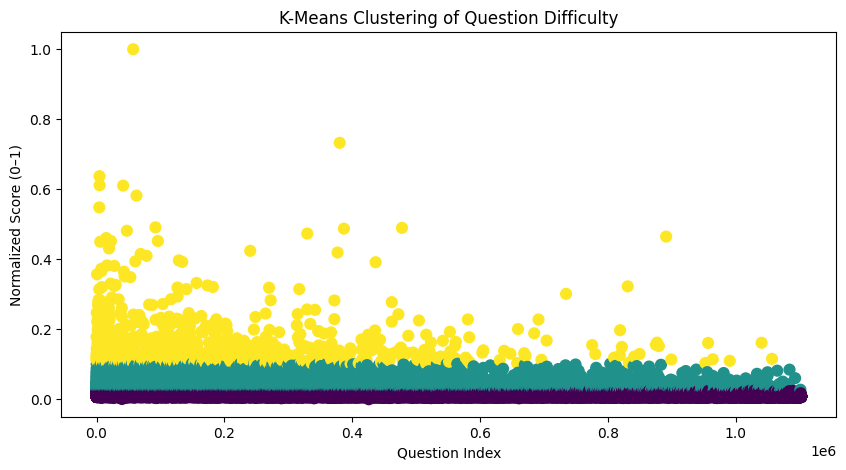

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

plt.scatter(
    answer_stats.index,
    answer_stats['avg_score_normalized'],
    c=answer_stats['cluster'],
    cmap='viridis',
    s=60
)

plt.xlabel("Question Index")
plt.ylabel("Normalized Score (0–1)")
plt.title("K-Means Clustering of Question Difficulty")

plt.show()

In [48]:
from scipy.sparse import load_npz

# Load cleaned answers
clean_answers = pd.read_csv("../data/processed/answers_clean.csv")

# Load saved vectorizer
vectorizer = joblib.load("../data/processed/tfidf_vectorizer.pkl")

# Transform answers (DO NOT FIT AGAIN)
tfidf_answers = vectorizer.transform(clean_answers["clean_text"].fillna(""))

print("Answers TF-IDF Shape:", tfidf_answers.shape)

# Save sparse matrix
save_npz("../data/processed/answers_tfidf.npz", tfidf_answers)

print("Answers TF-IDF saved successfully.")


Answers TF-IDF Shape: (2014516, 10000)
Answers TF-IDF saved successfully.


In [50]:
# Scalling the score and made it till out of 100


# calculated the averge by group of that that particular question id.
# clean_answers['average_score'] = (clean_answers.groupby('Id')['score_out_of_100'].transform('mean'))

# # added a new column of difficulty label and hardcoded the bins such that if average score defines the difficulty.
# def assign_difficulty(score):
#     if score >= 70:
#         return "Easy"
#     elif score >= 40:
#         return "Medium" 
#     else:
#         return "Hard"

# clean_answers['difficulty'] = (
#     clean_answers['average_score']
#     .apply(assign_difficulty)
# )

clean_answers.head()

,Id,Score,clean_text
0,92,13,version control subversion good resource sourc...
1,124,12,wound using kind hack actually works pretty we...
2,199,1,read somewhere human eye distinguish less valu...
3,269,4,yes thought soon figured another domain specif...
4,307,28,oleg shilo c script solution code project real...
